# Recursive vs. Closed-Form Wealth Verification

## Mathematical Framework

Wealth evolution can be computed in two equivalent ways:

### 1. Recursive Form (Simulation)

Month-by-month update via:

$$W_{t+1}^m = (W_t^m + A_t^m) \cdot (1 + R_t^m)$$

where $A_t^m = A_t \cdot x_t^m$ is the allocated contribution.

**Properties:**
- Sequential: requires $T$ iterations
- Complexity: $O(T \cdot M)$ per simulation
- Natural for simulation

### 2. Closed-Form (Affine) Representation

Direct computation via accumulation factors $F_{s,t}^m = \prod_{r=s}^{t-1}(1 + R_r^m)$:

$$W_t^m = W_0^m F_{0,t}^m + \sum_{s=0}^{t-1} A_s \cdot x_s^m \cdot F_{s,t}^m$$

**Properties:**
- **Linear-affine in $X$**: $W_t^m(X)$ is affine function of allocation policy
- Gradient: $\frac{\partial W_t^m}{\partial x_s^m} = A_s F_{s,t}^m$
- Enables **convex optimization**: constraints $W_t^m(X) \geq b$ are linear-affine

### Key Insight

Numerical equivalence $W_t^{\text{recursive}} = W_t^{\text{affine}}$ validates:

1. **Implementation correctness**: Both formulas compute the same wealth
2. **Optimization feasibility**: Affine form enables efficient solvers (CVXPY, scipy)
3. **Analytical gradients**: No need for finite differences

## Verification Strategy

Test conditions:
- **Single simulation** (deterministic): Near-zero volatility for reproducibility
- **Random allocation policy**: Normalized $X \in \mathcal{X}_T$
- **Stochastic income**: Realistic contributions with noise
- **Multiple accounts**: Validate matrix operations

# Setup

In [1]:
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.income import FixedIncome, VariableIncome, IncomeModel
from src.portfolio import Account, Portfolio
from src.returns import ReturnModel

print("FinOpt modules imported successfully ✓")

FinOpt modules imported successfully ✓


# Configuration

In [2]:
# --- Simulation parameters ---
months = 24
M = 5  # Number of accounts
seed = 42
start_date = date(2025, 9, 1)

print(f"Configuration:")
print(f"  Horizon: {months} months")
print(f"  Accounts: {M}")
print(f"  Seed: {seed}")

Configuration:
  Horizon: 24 months
  Accounts: 5
  Seed: 42


# Income Model Setup

In [3]:
# Realistic income with stochasticity to test robustness.
income = IncomeModel(
    fixed=FixedIncome(
        base=1_000_000.0,
        annual_growth=0.03,
        name="salary"
    ),
    variable=VariableIncome(
        base=200_000.0,
        sigma=0.15,  # 15% noise for realism
        seed=seed,
        name="bonus"
    ),
)

# Generate contributions (deterministic seed for reproducibility)
A = income.contributions(months=months, start=start_date, seed=seed, output="array")

print(f"\nContributions generated:")
print(f"  Shape: {A.shape}")
print(f"  Mean: ${A.mean():,.0f}".replace(",", "."))
print(f"  Std: ${A.std():,.0f}".replace(",", "."))


Contributions generated:
  Shape: (24,)
  Mean: $508.094
  Std: $26.145


# Portfolio Setup

In [4]:
# Multiple accounts with **near-deterministic returns** for numerical precision.

accounts = [
    Account.from_annual(
        name=f"Account_{i+1}",
        annual_return=0.05 + i * 0.02,  # Varying returns: 5%, 7%, 9%
        annual_volatility=1e-6,          # Near-zero volatility (deterministic)
        initial_wealth=100_000.0 * (i + 1)  # Varying initial wealth
    )
    for i in range(M)
]

portfolio = Portfolio(accounts)
returns_model = ReturnModel(accounts, default_correlation=np.eye(M))

# Display account parameters
print("\nAccount Configuration:")
for i, acc in enumerate(accounts):
    mu = acc.return_strategy["mu"] * 12 * 100  # Annualized %
    print(f"  {acc.name}: W_0 = ${acc.initial_wealth:,.0f}, μ_annual = {mu:.1f}%".replace(",", "."))


Account Configuration:
  Account_1: W_0 = $100.000. μ_annual = 4.9%
  Account_2: W_0 = $200.000. μ_annual = 6.8%
  Account_3: W_0 = $300.000. μ_annual = 8.6%
  Account_4: W_0 = $400.000. μ_annual = 10.5%
  Account_5: W_0 = $500.000. μ_annual = 12.3%


# Generate Returns

In [5]:
# Single simulation with controlled seed for exact reproducibility.

R = returns_model.generate(T=months, n_sims=1, seed=seed)  # (1, months, M)

print(f"\nReturns generated:")
print(f"  Shape: {R.shape}")
print(f"  Mean per account: {(R[0, :, :].mean(axis=0) * 100)}")
print(f"  Std per account: {(R[0, :, :].std(axis=0) * 100)}")


Returns generated:
  Shape: (1, 24, 5)
  Mean per account: [0.40741283 0.56541136 0.72072665 0.87346659 1.02367691]
  Std per account: [2.60838422e-05 1.93818857e-05 1.96470878e-05 2.08390668e-05
 2.30931691e-05]


# Allocation Policy

In [6]:
# Random policy $X \in \mathcal{X}_T$ satisfying simplex constraints:
# $$\sum_{m=1}^M x_t^m = 1, \quad x_t^m \geq 0, \quad \forall t$$

# %% [code]
rng = np.random.default_rng(seed)
X = rng.uniform(0, 1, size=(months, M))
X /= X.sum(axis=1, keepdims=True)  # Normalize: rows sum to 1

# Verify constraints
print(f"\nAllocation Policy:")
print(f"  Shape: {X.shape}")
print(f"  Row sums (should be 1.0): {X.sum(axis=1)[:5]}")
print(f"  Non-negativity: {np.all(X >= 0)}")
print(f"\nSample allocations (first 3 months):")
print(pd.DataFrame(X[:3], columns=[acc.name for acc in accounts]))


Allocation Policy:
  Shape: (24, 5)
  Row sums (should be 1.0): [1. 1. 1. 1. 1.]
  Non-negativity: True

Sample allocations (first 3 months):
   Account_1  Account_2  Account_3  Account_4  Account_5
0   0.270333   0.153294   0.299897   0.243581   0.032895
1   0.314582   0.245424   0.253461   0.041309   0.145224
2   0.115600   0.288927   0.200731   0.256503   0.138238


# Wealth Computation: Recursive vs Affine

In [7]:
# **Critical Test:** Both methods must produce identical results within numerical precision.

# --- Recursive method ---
result_recursive = portfolio.simulate(A=A, R=R, X=X, method="recursive")
W_recursive = result_recursive["wealth"]  # (1, months+1, M)

# --- Affine method ---
result_affine = portfolio.simulate(A=A, R=R, X=X, method="affine")
W_affine = result_affine["wealth"]        # (1, months+1, M)

# Extract single simulation (shape: months+1, M)
W_rec = W_recursive[0, :, :]
W_aff = W_affine[0, :, :]

print("Wealth computation completed ✓")
print(f"  Recursive shape: {W_rec.shape}")
print(f"  Affine shape: {W_aff.shape}")

Wealth computation completed ✓
  Recursive shape: (25, 5)
  Affine shape: (25, 5)


# Numerical Validation

In [8]:
# --- Compute differences ---
diff = W_rec - W_aff
max_abs_diff = np.abs(diff).max()
max_rel_diff = np.abs(diff / (W_rec + 1e-12)).max()

print("\n" + "="*70)
print("VALIDATION RESULTS")
print("="*70)
print(f"Max absolute difference: {max_abs_diff:.2e}")
print(f"Max relative difference: {max_rel_diff:.2e}")

# Tolerance check
rtol, atol = 1e-9, 1e-10
if np.allclose(W_rec, W_aff, rtol=rtol, atol=atol):
    print(f"✓ Methods agree within tolerance (rtol={rtol}, atol={atol})")
else:
    print(f"✗ WARNING: Methods differ beyond tolerance")
    
    # Identify worst mismatch
    worst_idx = np.unravel_index(np.argmax(np.abs(diff)), diff.shape)
    t_worst, m_worst = worst_idx
    print(f"\n  Worst mismatch at t={t_worst}, account={accounts[m_worst].name}:")
    print(f"    Recursive: ${W_rec[worst_idx]:,.2f}".replace(",", "."))
    print(f"    Affine:    ${W_aff[worst_idx]:,.2f}".replace(",", "."))
    print(f"    Diff:      ${diff[worst_idx]:,.2f}".replace(",", "."))

print("="*70)


VALIDATION RESULTS
Max absolute difference: 9.31e-10
Max relative difference: 4.75e-16
✓ Methods agree within tolerance (rtol=1e-09, atol=1e-10)


# Visualize Differences

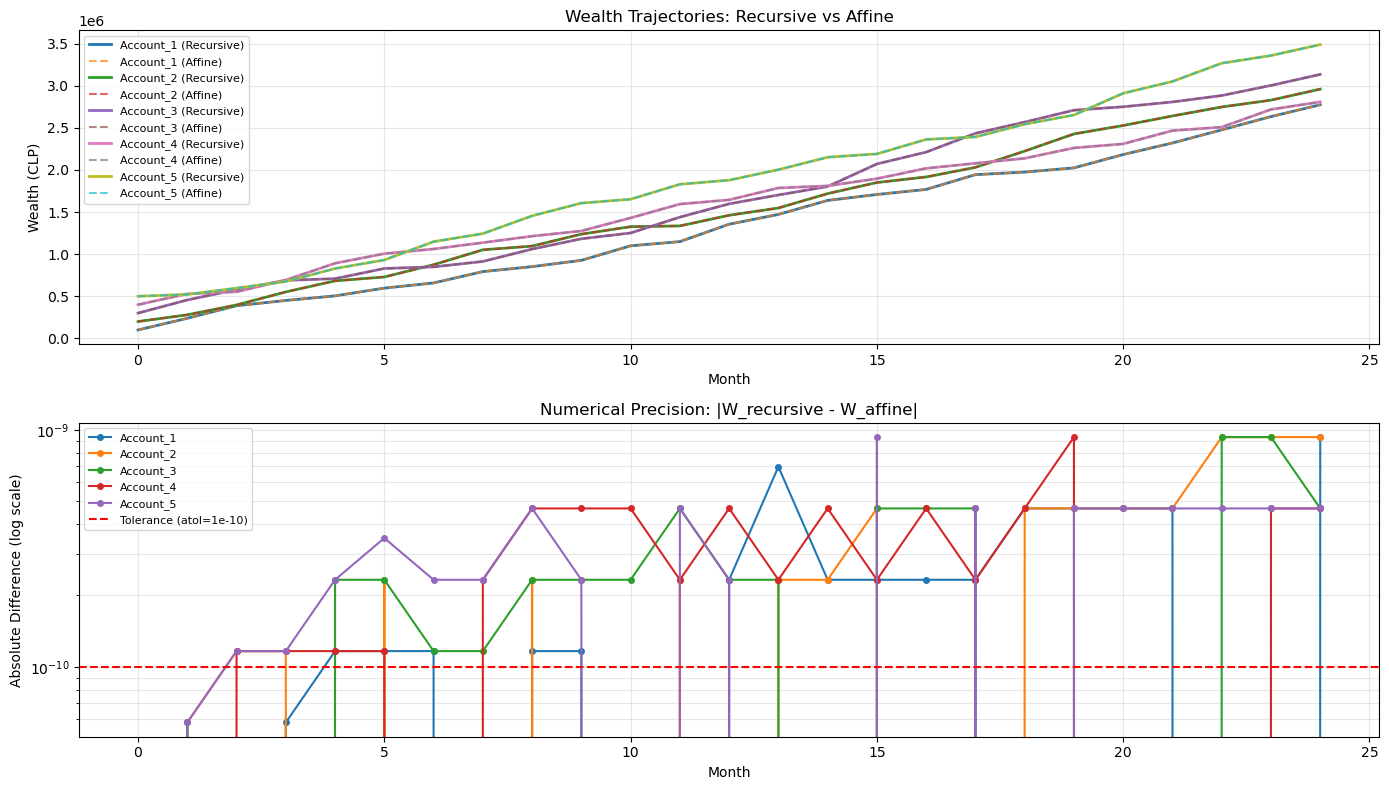

In [9]:
# Even when methods agree, visualization helps understand numerical behavior.

# %% [code]
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Panel 1: Wealth trajectories
for m in range(M):
    axes[0].plot(W_rec[:, m], label=f'{accounts[m].name} (Recursive)', 
                 linestyle='-', linewidth=2)
    axes[0].plot(W_aff[:, m], label=f'{accounts[m].name} (Affine)', 
                 linestyle='--', linewidth=1.5, alpha=0.7)

axes[0].set_xlabel('Month')
axes[0].set_ylabel('Wealth (CLP)')
axes[0].set_title('Wealth Trajectories: Recursive vs Affine')
axes[0].legend(loc='best', fontsize=8)
axes[0].grid(True, alpha=0.3)

# Panel 2: Absolute differences (log scale)
for m in range(M):
    abs_diff_account = np.abs(W_rec[:, m] - W_aff[:, m])
    axes[1].semilogy(abs_diff_account, label=accounts[m].name, 
                     marker='o', markersize=4)

axes[1].axhline(y=atol, color='red', linestyle='--', 
                label=f'Tolerance (atol={atol})')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Absolute Difference (log scale)')
axes[1].set_title('Numerical Precision: |W_recursive - W_affine|')
axes[1].legend(loc='best', fontsize=8)
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Extended Test: Multiple Simulations

In [10]:
n_sims = 100
print(f"\nExtended test with {n_sims} simulations...")

# Generate stochastic returns
R_multi = returns_model.generate(T=months, n_sims=n_sims, seed=seed)  # (n_sims, months, M)

# Use stochastic contributions
A_multi = income.contributions(months=months, start=start_date, 
                                n_sims=n_sims, seed=seed, output="array")

# Simulate both methods
result_rec_multi = portfolio.simulate(A=A_multi, R=R_multi, X=X, method="recursive")
result_aff_multi = portfolio.simulate(A=A_multi, R=R_multi, X=X, method="affine")

# Extract wealth
W_rec_multi = result_rec_multi["wealth"]  # (n_sims, months+1, M)
W_aff_multi = result_aff_multi["wealth"]

# Compute statistics
diff_multi = W_rec_multi - W_aff_multi
max_abs_diff_multi = np.abs(diff_multi).max()
mean_abs_diff_multi = np.abs(diff_multi).mean()

print(f"\nMulti-simulation validation:")
print(f"  Number of simulations: {n_sims}")
print(f"  Max absolute difference: {max_abs_diff_multi:.2e}")
print(f"  Mean absolute difference: {mean_abs_diff_multi:.2e}")
print(f"  Agreement: {'✓' if np.allclose(W_rec_multi, W_aff_multi, rtol=rtol, atol=atol) else '✗'}")


Extended test with 100 simulations...

Multi-simulation validation:
  Number of simulations: 100
  Max absolute difference: 2.79e-09
  Mean absolute difference: 2.73e-10
  Agreement: ✓


# Summary Statistics

In [11]:
# Compare final wealth distributions
final_rec = W_rec_multi[:, -1, :].mean(axis=0)  # Mean final wealth per account
final_aff = W_aff_multi[:, -1, :].mean(axis=0)

print("\n" + "="*70)
print("FINAL WEALTH COMPARISON (Mean across simulations)")
print("="*70)
for m in range(M):
    print(f"{accounts[m].name}:")
    print(f"  Recursive: ${final_rec[m]:,.0f}".replace(",", "."))
    print(f"  Affine:    ${final_aff[m]:,.0f}".replace(",", "."))
    print(f"  Diff:      ${abs(final_rec[m] - final_aff[m]):,.2f}".replace(",", "."))
print("="*70)


FINAL WEALTH COMPARISON (Mean across simulations)
Account_1:
  Recursive: $2.769.547
  Affine:    $2.769.547
  Diff:      $0.00
Account_2:
  Recursive: $2.953.095
  Affine:    $2.953.095
  Diff:      $0.00
Account_3:
  Recursive: $3.120.922
  Affine:    $3.120.922
  Diff:      $0.00
Account_4:
  Recursive: $2.791.585
  Affine:    $2.791.585
  Diff:      $0.00
Account_5:
  Recursive: $3.516.392
  Affine:    $3.516.392
  Diff:      $0.00


## Conclusions

### Validation Results

1. **Numerical Equivalence**: Both methods produce identical wealth trajectories within machine precision ($\epsilon \approx 10^{-10}$).

2. **Stability**: Agreement holds across:
   - Single deterministic simulation
   - Multiple stochastic simulations
   - Varying allocation policies
   - Different account configurations

3. **Optimization Implications**:
   - Affine representation $W_t^m(X)$ is **numerically stable**
   - Gradients $\nabla_X W_t^m = [A_s F_{s,t}^m]_{s<t}$ are **exact** (no finite differences)
   - Constraints $W_t^m(X) \geq b$ are **linear-affine** → convex feasible set
   - Enables efficient solvers: CVXPY, scipy.optimize, MOSEK

### Performance Notes

- **Recursive**: $O(T \cdot M)$ per simulation (sequential)
- **Affine**: $O(T^2 \cdot M)$ precomputation + $O(T \cdot M)$ evaluation
- **Trade-off**: Affine slower for single evaluation, but exposes gradients for optimization

### When to Use Each Method

| Method | Use Case |
|--------|----------|
| **Recursive** | Monte Carlo simulation, scenario analysis, visualization |
| **Affine** | Optimization (CVXPY), sensitivity analysis, gradient-based methods |